In [1]:
#Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

import os
#Defaults to 0, so all logs are shown. Set TF_CPP_MIN_LOG_LEVEL to 1 to filter out INFO logs, 2 to additionall filter out WARNING, 3 to additionally filter out ERROR.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np 
import pandas as pd 
import tensorflow as tf

import os
import matplotlib.pyplot as plt
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)
(5000, 28, 28, 1)
(5000, 10)
(10000, 28, 28, 1)
(10000, 10)


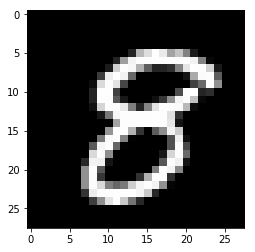

In [2]:
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

#Data parameters
image_width = 28
image_height = 28
num_classes = 10
#It is a grayscale so it has only one channel
num_channels = 1

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Xtrain = mnist.train.images
Xtrain = Xtrain
ytrain = mnist.train.labels

Xvalid = mnist.validation.images
Xvalid = Xvalid.reshape((-1, image_width, image_height, num_channels))
yvalid = mnist.validation.labels

Xtest = mnist.test.images
Xtest = Xtest.reshape([-1, image_width, image_height, num_channels])
ytest = mnist.test.labels

tf.logging.set_verbosity(old_v)

print(Xtrain.shape)
print(ytrain.shape)
print(Xvalid.shape)
print(yvalid.shape)
print(Xtest.shape)
print(ytest.shape)


#Plot one image
plt.imshow(mnist.train.images.reshape((-1, image_width, image_height, num_channels))[55, :, :, 0], cmap="gray", interpolation="nearest")

In [3]:
#In this tutorial, we use tf.layers API.
#tf.layers.conv2d uses tf.nn.convolution
#the main difference of tf.nn and tf.layers conv2d is that for tf.nn, you need to create your own filter tensor 
#and pass it in. This filter needs to have the size of: [kernel_height, kernel_width, in_channels, num_filters]
#https://stackoverflow.com/questions/45172725/tensorflow-why-are-there-so-many-similar-or-even-duplicate-functions-in-tf-nn
learning_rate = 0.0001

graph = tf.Graph()
with graph.as_default():
    #Define the placeholders
    with tf.name_scope("graph_inputs"):
        X = tf.placeholder(dtype=tf.float32,shape=[None, image_width, image_height, num_channels], name="input_placeholder")
        y = tf.placeholder(dtype=tf.float32,shape=[None, num_classes],name="input_placeholder")
        keep_prob_ = tf.placeholder_with_default(1.0, shape=(), name ="dropout_rate")
        
    #Define the model
    with tf.name_scope("CNN"):
        with tf.name_scope("Model"):
            conv1 = tf.layers.conv2d(X, filters = 32, kernel_size=[5,5], strides=[1,1], padding = "SAME", activation=tf.nn.relu)
            #shape=(batch_size, 28, 28, 32)
            MaxPool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=[2,2], padding='SAME')
            #shape=(batch_size, 14, 14, 32)
            conv2 = tf.layers.conv2d(MaxPool1, filters = 64, kernel_size=[5,5], strides=[1,1], padding = "SAME", activation=tf.nn.relu)
            #shape=(batch_size, 14, 14, 64
            MaxPool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=[2,2], padding='SAME')
            #shape=(batch_size, 7, 7, 64)
            flat_layer = tf.layers.flatten(MaxPool2)
            #shape=(batch_size, 3136)
            dense_layer = tf.layers.dense(inputs = flat_layer, units = 1024, activation=tf.nn.relu)
            #shape=(batch_size, 1024)
            dropout_layer = tf.nn.dropout(dense_layer, keep_prob = keep_prob_)
            #just some neurons dropped in order to prevent overfitting. Shape does not change.
            #shape=(batch_size, 1024)
        with tf.variable_scope('Logits'):
            # Reduce the dimensions to num_classes
            logits = tf.layers.dense(inputs = dense_layer, units = 10)
            #shape=(batch_size, 10)
        with tf.name_scope('Predictions'):
            predictions = tf.nn.softmax(logits, name="predictions")  #[Batch_size, num_classes]
        with tf.name_scope('Loss'):
            #Classes are one-hot encoded. If they were not,
            #use tf.nn.sparse_softmax_cross_entropy_with_logits
            xentropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y)
            loss = tf.reduce_mean(xentropy)
        with tf.name_scope('Train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            trainer = optimizer.minimize(loss)
        with tf.name_scope("Accuracy"):
            accuracy, accuracy_update_op  = tf.metrics.accuracy(labels = tf.argmax(y, axis = 1), predictions = tf.argmax(predictions, axis = 1), name = 'accuracy')
            running_vars_accuracy = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="CNN/Accuracy")
        with tf.name_scope("Saver"):
            saver = tf.train.Saver(var_list=tf.trainable_variables()) 
        with tf.name_scope("init"):
            global_variables_init = tf.global_variables_initializer()
            running_vars_initializer_accuracy = tf.variables_initializer(var_list=running_vars_accuracy)

In [4]:
#Network Parameters
num_epochs = 10
batch_size = 128

with tf.Session(graph=graph) as sess:
    global_variables_init.run()
    graph.finalize()
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        avg_cost_train = 0.
        total_train_batch = int((mnist.train.num_examples/batch_size) + 1)

        running_vars_initializer_accuracy.run()
        for batch in range(total_train_batch):
            xBatch_train, yBatch_train = mnist.train.next_batch(batch_size)
            xBatch_train = xBatch_train.reshape((-1, image_width, image_height, num_channels))
            _, miniBatchCost_train, miniBatchAccuracy_train = sess.run([trainer, loss, accuracy_update_op], feed_dict = {X: xBatch_train, y: yBatch_train, keep_prob_: 0.5})
            avg_cost_train += miniBatchCost_train / total_train_batch
        accuracy_train = sess.run(accuracy)
        train_loss.append(avg_cost_train)
        train_acc.append(accuracy_train)
        
        
        avg_cost_val = 0.
        total_val_batch = int((mnist.validation.num_examples/batch_size) + 1)
        running_vars_initializer_accuracy.run()
        for batch in range(total_val_batch):
            xBatch_val, yBatch_val = mnist.validation.next_batch(batch_size)
            xBatch_val = xBatch_val.reshape((-1, image_width, image_height, num_channels))
            miniBatchCost_val, miniBatchAccuracy_val= sess.run([loss, accuracy_update_op], feed_dict = {X: xBatch_val, y: yBatch_val, keep_prob_: 1.0})
            avg_cost_val += miniBatchCost_val / total_val_batch
        accuracy_val = sess.run(accuracy)
        val_loss.append(avg_cost_val)
        val_acc.append(accuracy_val)
        
        
        print("Epoch: {:d}-".format(epoch), \
              "Training Loss: {:.6f}, ".format(avg_cost_train), \
              "Training Accuracy: {:>.2%}, ".format(accuracy_train), \
              "Validation Loss: {:.6f}, ".format(avg_cost_val), \
              "Validation Accuracy: {:>.2%},".format(accuracy_val))

    print("Optimization Finished!")
    
    print("Saving the model...")
    final_model_path = "./my_deep_model.ckpt"
    saver.save(sess, final_model_path)
    
        
    print("Evaluating on testing data...")
    running_vars_initializer_accuracy.run()
    Xtest = mnist.test.images
    Xtest = Xtest.reshape([-1, image_width, image_height, num_channels])
    ytest = mnist.test.labels
    predictions_test, _= sess.run([predictions, accuracy_update_op], feed_dict={X:Xtest, y: ytest, keep_prob_: 1.0})
    accuracy_test = sess.run(accuracy)
    print("Final test accuracy: {:>.2%}".format(accuracy_test)) 

Epoch: 0- Training Loss: 0.426651,  Training Accuracy: 88.63%,  Validation Loss: 0.135964,  Validation Accuracy: 96.27%,
Epoch: 1- Training Loss: 0.111080,  Training Accuracy: 96.76%,  Validation Loss: 0.081283,  Validation Accuracy: 97.42%,
Epoch: 2- Training Loss: 0.074570,  Training Accuracy: 97.79%,  Validation Loss: 0.055082,  Validation Accuracy: 98.36%,
Epoch: 3- Training Loss: 0.057972,  Training Accuracy: 98.22%,  Validation Loss: 0.053509,  Validation Accuracy: 98.36%,
Epoch: 4- Training Loss: 0.046853,  Training Accuracy: 98.58%,  Validation Loss: 0.051286,  Validation Accuracy: 98.36%,
Epoch: 5- Training Loss: 0.039962,  Training Accuracy: 98.78%,  Validation Loss: 0.037255,  Validation Accuracy: 99.08%,
Epoch: 6- Training Loss: 0.034635,  Training Accuracy: 98.94%,  Validation Loss: 0.045253,  Validation Accuracy: 98.67%,
Epoch: 7- Training Loss: 0.030550,  Training Accuracy: 99.09%,  Validation Loss: 0.037211,  Validation Accuracy: 99.10%,
Epoch: 8- Training Loss: 0.02695

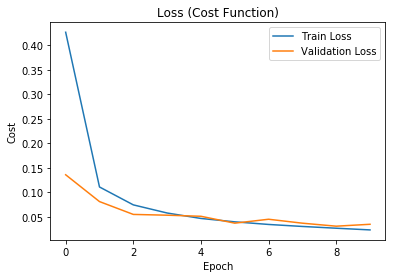

In [5]:
#Visualize the loss
plt.figure(1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title("Loss (Cost Function)")
plt.legend()
plt.show()

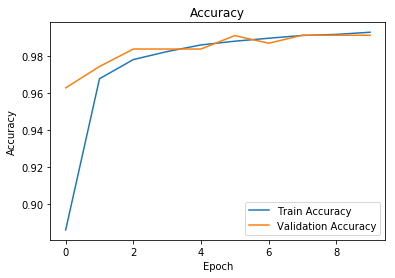

In [6]:
#Visualize the Accuracy
plt.figure(2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()